# Arbor-Neuron validation output analysis

In [1]:
import re
import json
import pandas
import matplotlib.pyplot as plt
from IPython.display import display

Tests with OK status:

In [2]:
%%bash

rm tests_{ok,error,na} || true
grep test_l5pc\ OK l5pc_validate_neuron_arbor_* | tee tests_ok

l5pc_validate_neuron_arbor_all.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00101 (0.05), 1.7e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_all.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000381 (0.05), 2.13e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00275 (0.05), 6.49e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im.ipynb:      "Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000598 (0.05), 8.77e-07 (0.0005).\n"
l5pc_validate_neuron_arbor_apical_Ih_Im_NaTs2_t.ipynb:      "Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.00379 (0.05), 2.3e-07 (0.0005).\n"
l5pc_valida

Tests with ERROR status:

In [3]:
%%bash

grep test_l5pc\ ERROR l5pc_validate_neuron_arbor_* | tee tests_error

l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Pst_Nap_Et2.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.0562 (0.05), 2.51e-07 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Pst_Nap_Et2.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.0562 (0.05), 1.4e-07 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.687 (0.05), 2.86e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst.ipynb:      "Fine dt (0.001): test_l5pc ERROR! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.687 (0.05), 2.85e-08 (0.0005).\n"
l5pc_validate_neuron_arbor_axonal_CaDynamics_E2_K_Tst_NaTa_t.ipynb:      "Default dt (0.025): test_l5pc ERROR! The mean relat

Tests with N/A result:

In [4]:
%%bash

touch tests_na
for f in $(ls l5pc_validate_neuron_arbor_*); do 
    if ! grep test_l5pc\ OK $f > /dev/null && ! grep test_l5pc\ ERROR $f > /dev/null; then 
        echo "$f" | tee -a tests_na
    fi
done

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_SK_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb


In [5]:
# Read output
with open('tests_ok') as f:
    tests_ok = f.readlines()

with open('tests_error') as f:
    tests_error = f.readlines()

with open('tests_na') as f:
    tests_na = f.readlines()

Display test results. Test status can be ERROR due to relative L1-norm exceeding the tolerance or, similarly, the quadrature error exceeding a lower threshold. 

In [6]:
def parse_test_status_line(line):
    numeric_vars = ['dt', 'l1_norm', 'l1_tol', 'l1_error', 'l1_error_tol']
    numbers = [r'(?P<{}>[+\-]?\d+[\.]?\d*[eE]?[+\-]?\d*)'.format(name) 
               for name in numeric_vars]
    test_status_pattern = r'^(?P<filename>l5pc_validate_neuron_arbor_\w+.ipynb):\s+\"(?P<dt_setting>Default|Fine) dt \({}\): test_l5pc (?P<test_result>OK|ERROR)! [\w\s-]+\(tol in brackets\) are {} \({}\), {} \({}\)'.format(*numbers)
    match = re.search(test_status_pattern, line)
    groupdict = match.groupdict()
    for v in numeric_vars:
        groupdict[v] = float(groupdict[v])
    return groupdict


# extract params from executed notebooks
def extract_mechs_params(filename):
    with open(filename) as f:
        nb = json.load(f)
    # print(nb['cells'][2]['source'])
    exec('global mechanism_defs\nglobal extra_params\n' + ''.join(nb['cells'][2]['source']))
    return mechanism_defs, extra_params


test_results = []
for line in tests_ok + tests_error:
    result = parse_test_status_line(line)
    region_mechs = result['filename'][len('l5pc_validate_neuron_arbor_'):-len('.ipynb')].split('_')
    result['region'] = region_mechs[0]
    result['mechs_str'] = '_'.join(region_mechs[1:])
    
    mechs, params = extract_mechs_params(result['filename'])    
    result['mechs'] = mechs
    result['extra_params'] = extra_params
    test_results.append(result)

test_status_df = pandas.DataFrame(test_results)
regional_test_status = dict()

max_rows_default = pandas.options.display.max_rows
pandas.options.display.max_rows = None  # uncomment for full view
for region, regional_test_status_df in test_status_df.groupby(['region']):
    regional_test_status[region] = regional_test_status_df.sort_values(by='l1_norm', ascending=False)
    display(regional_test_status[region])
pandas.options.display.max_rows = max_rows_default

,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
0,l5pc_validate_neuron_arbor_all.ipynb,Default,0.025,OK,0.001010,0.05,1.700000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."
1,l5pc_validate_neuron_arbor_all.ipynb,Fine,0.001,OK,0.000381,0.05,2.130000e-08,0.0005,all,,{'all': ['pas']},"{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
22,l5pc_validate_neuron_arbor_apical_Im_SKv3_1_Na...,Default,0.025,OK,0.006470,0.05,1.470000e-07,0.0005,apical,Im_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
24,l5pc_validate_neuron_arbor_apical.ipynb,Default,0.025,OK,0.006460,0.05,1.330000e-07,0.0005,apical,,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
14,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1_Na...,Default,0.025,OK,0.006070,0.05,8.470000e-07,0.0005,apical,Ih_SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1', 'N...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
30,l5pc_validate_neuron_arbor_apical_SKv3_1_NaTs2...,Default,0.025,OK,0.005880,0.05,5.060000e-07,0.0005,apical,SKv3_1_NaTs2_t,"{'all': ['pas'], 'apical': ['SKv3_1', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
4,l5pc_validate_neuron_arbor_apical_Ih_Im_NaTs2_...,Default,0.025,OK,0.003790,0.05,2.300000e-07,0.0005,apical,Ih_Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'NaTs2...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
12,l5pc_validate_neuron_arbor_apical_Ih_SKv3_1.ipynb,Default,0.025,OK,0.003790,0.05,4.290000e-07,0.0005,apical,Ih_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
18,l5pc_validate_neuron_arbor_apical_Im_NaTs2_t.i...,Default,0.025,OK,0.003740,0.05,2.250000e-07,0.0005,apical,Im_NaTs2_t,"{'all': ['pas'], 'apical': ['Im', 'NaTs2_t']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
20,l5pc_validate_neuron_arbor_apical_Im_SKv3_1.ipynb,Default,0.025,OK,0.003570,0.05,7.500000e-08,0.0005,apical,Im_SKv3_1,"{'all': ['pas'], 'apical': ['Im', 'SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
28,l5pc_validate_neuron_arbor_apical_SKv3_1.ipynb,Default,0.025,OK,0.003560,0.05,3.700000e-07,0.0005,apical,SKv3_1,"{'all': ['pas'], 'apical': ['SKv3_1']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
6,l5pc_validate_neuron_arbor_apical_Ih_Im_SKv3_1...,Default,0.025,OK,0.003500,0.05,3.450000e-07,0.0005,apical,Ih_Im_SKv3_1,"{'all': ['pas'], 'apical': ['Ih', 'Im', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
318,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Default,0.025,ERROR,0.687000,0.05,2.860000e-08,0.0005,axonal,CaDynamics_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
319,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Fine,0.001,ERROR,0.687000,0.05,2.850000e-08,0.0005,axonal,CaDynamics_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
360,l5pc_validate_neuron_arbor_axonal_K_Tst.ipynb,Default,0.025,ERROR,0.687000,0.05,2.830000e-08,0.0005,axonal,K_Tst,"{'all': ['pas'], 'axonal': ['K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
361,l5pc_validate_neuron_arbor_axonal_K_Tst.ipynb,Fine,0.001,ERROR,0.687000,0.05,2.620000e-08,0.0005,axonal,K_Tst,"{'all': ['pas'], 'axonal': ['K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
372,l5pc_validate_neuron_arbor_axonal_SK_E2_K_Tst....,Fine,0.001,ERROR,0.681000,0.05,2.140000e-08,0.0005,axonal,SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['SK_E2', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
371,l5pc_validate_neuron_arbor_axonal_SK_E2_K_Tst....,Default,0.025,ERROR,0.681000,0.05,1.780000e-08,0.0005,axonal,SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['SK_E2', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
323,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Fine,0.001,ERROR,0.678000,0.05,2.260000e-08,0.0005,axonal,CaDynamics_E2_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
322,l5pc_validate_neuron_arbor_axonal_CaDynamics_E...,Default,0.025,ERROR,0.677000,0.05,1.720000e-08,0.0005,axonal,CaDynamics_E2_SK_E2_K_Tst,"{'all': ['pas'], 'axonal': ['CaDynamics_E2', '...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
347,l5pc_validate_neuron_arbor_axonal_Ca_LVAst_K_T...,Fine,0.001,ERROR,0.674000,0.05,3.990000e-08,0.0005,axonal,Ca_LVAst_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
346,l5pc_validate_neuron_arbor_axonal_Ca_LVAst_K_T...,Default,0.025,ERROR,0.674000,0.05,3.950000e-08,0.0005,axonal,Ca_LVAst_K_Tst,"{'all': ['pas'], 'axonal': ['Ca_LVAst', 'K_Tst']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
207,l5pc_validate_neuron_arbor_basal.ipynb,Default,0.025,OK,0.000871,0.05,1.340000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
208,l5pc_validate_neuron_arbor_basal.ipynb,Fine,0.001,OK,0.000363,0.05,3.770000e-08,0.0005,basal,,"{'all': ['pas'], 'basal': ['Ih']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."


,filename,dt_setting,dt,test_result,l1_norm,l1_tol,l1_error,l1_error_tol,region,mechs_str,mechs,extra_params
388,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.093000,0.05,1.310000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ca_HVA,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
392,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.092900,0.05,2.170000e-06,0.0005,somatic,NaTs2_t_SKv3_1_SK_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
391,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.091200,0.05,9.020000e-07,0.0005,somatic,NaTs2_t_SKv3_1,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
387,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.087100,0.05,1.660000e-06,0.0005,somatic,NaTs2_t_SKv3_1_CaDynamics_E2,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
390,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.084500,0.05,1.560000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ih,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
389,l5pc_validate_neuron_arbor_somatic_NaTs2_t_SKv...,Default,0.025,ERROR,0.078800,0.05,1.770000e-06,0.0005,somatic,NaTs2_t_SKv3_1_Ca_LVAst,"{'all': ['pas'], 'somatic': ['NaTs2_t', 'SKv3_...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
270,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.028700,0.05,2.240000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
271,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Fine,0.001,OK,0.028300,0.05,6.080000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ca_LVAst,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."
274,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.027600,0.05,1.890000e-08,0.0005,somatic,SK_E2_Ca_HVA,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA']}","{'v_init': 'global', 'celsius': 'global', 'g_p..."
272,l5pc_validate_neuron_arbor_somatic_SK_E2_Ca_HV...,Default,0.025,OK,0.027600,0.05,2.960000e-08,0.0005,somatic,SK_E2_Ca_HVA_Ih,"{'all': ['pas'], 'somatic': ['SK_E2', 'Ca_HVA'...","{'v_init': 'global', 'celsius': 'global', 'g_p..."


We can rank-order the mechs w.r.t. the L1-deviation on each region and for each `dt` configuration.

In [7]:
def regional_rank_stats(region, regional_test_status):
    regional_mechs = regional_test_status[regional_test_status['mechs_str'] == ''].iloc[0]['mechs'][region]
    regional_mech_ranks = {dt_setting: [] for dt_setting in regional_test_status_df['dt_setting'].unique()}
    for mech in regional_mechs:
        for dt_setting, dt_group in regional_test_status_df.groupby('dt_setting'):
            regional_mech_ranks[dt_setting].append(dict(region=region, dt_setting=dt_setting, mech=mech))
            rank_stats = 1./len(dt_group)*dt_group['l1_norm'].rank(ascending=False)[ dt_group.apply(lambda r: mech in r['mechs_str'], axis=1) ].describe()
            for k, v in rank_stats.items():
                regional_mech_ranks[dt_setting][-1]['rank_' + k] = v
    return {dt_setting: pandas.DataFrame(dt_group).sort_values(by='rank_mean') for dt_setting, dt_group in regional_mech_ranks.items()}

mech_rank_stats = dict()
for region, regional_test_status_df in regional_test_status.items():
    mech_rank_stats[region] = dict()
    for dt_setting, rank_stats in regional_rank_stats(region, regional_test_status[region]).items():
        mech_rank_stats[region][dt_setting] = rank_stats
        display(rank_stats)

,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Default,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,all,Fine,pas,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Default,SKv3_1,0.466667,0.385714,0.222658,0.066667,0.233333,0.366667,0.566667,0.666667
3,apical,Default,NaTs2_t,0.466667,0.452381,0.331024,0.066667,0.233333,0.366667,0.666667,0.933333
1,apical,Default,Im,0.466667,0.519048,0.250819,0.066667,0.416667,0.533333,0.700000,0.800000
0,apical,Default,Ih,0.466667,0.609524,0.305938,0.200000,0.366667,0.666667,0.833333,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
2,apical,Fine,SKv3_1,0.466667,0.314286,0.191347,0.066667,0.166667,0.333333,0.433333,0.600000
3,apical,Fine,NaTs2_t,0.466667,0.485714,0.356348,0.066667,0.166667,0.533333,0.766667,0.933333
1,apical,Fine,Im,0.466667,0.571429,0.199470,0.200000,0.500000,0.600000,0.700000,0.800000
0,apical,Fine,Ih,0.466667,0.609524,0.334284,0.066667,0.433333,0.600000,0.866667,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
5,axonal,Default,K_Tst,0.292683,0.303749,0.247281,0.012195,0.079268,0.264228,0.475610,0.715447
6,axonal,Default,K_Pst,0.300813,0.376840,0.139128,0.178862,0.252033,0.382114,0.483740,0.634146
8,axonal,Default,NaTa_t,0.284553,0.446574,0.318021,0.093496,0.158537,0.272358,0.752033,0.918699
4,axonal,Default,SK_E2,0.292683,0.502371,0.286757,0.024390,0.315041,0.504065,0.742886,0.983740
0,axonal,Default,Ca_LVAst,0.276423,0.515423,0.304946,0.040650,0.315041,0.447154,0.773374,1.000000
3,axonal,Default,SKv3_1,0.300813,0.522962,0.227695,0.130081,0.430894,0.565041,0.634146,0.878049
2,axonal,Default,CaDynamics_E2,0.243902,0.523171,0.293105,0.012195,0.343496,0.516260,0.761179,0.975610
1,axonal,Default,Ca_HVA,0.260163,0.534553,0.289467,0.065041,0.315041,0.520325,0.806911,1.000000
7,axonal,Default,Nap_Et2,0.300813,0.721600,0.280762,0.195122,0.666667,0.853659,0.926829,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
5,axonal,Fine,K_Tst,0.292683,0.284327,0.222314,0.012195,0.079268,0.243902,0.487805,0.650407
6,axonal,Fine,K_Pst,0.300813,0.369809,0.151142,0.130081,0.268293,0.361789,0.455285,0.634146
8,axonal,Fine,NaTa_t,0.284553,0.452962,0.295256,0.093496,0.207317,0.325203,0.752033,0.894309
4,axonal,Fine,SK_E2,0.292683,0.498419,0.288634,0.024390,0.280488,0.475610,0.725610,0.987805
0,axonal,Fine,Ca_LVAst,0.276423,0.513749,0.309032,0.040650,0.294715,0.455285,0.800813,1.000000
2,axonal,Fine,CaDynamics_E2,0.243902,0.528184,0.292714,0.012195,0.322154,0.536585,0.760163,0.975610
1,axonal,Fine,Ca_HVA,0.260163,0.545224,0.298648,0.065041,0.280488,0.554878,0.829268,1.000000
3,axonal,Fine,SKv3_1,0.300813,0.566249,0.202723,0.195122,0.544715,0.617886,0.691057,0.902439
7,axonal,Fine,Nap_Et2,0.300813,0.668864,0.308547,0.138211,0.487805,0.796748,0.926829,1.000000


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Default,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
0,basal,Fine,Ih,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Default,SKv3_1,0.385965,0.326156,0.184014,0.017544,0.135965,0.372807,0.469298,0.561404
2,somatic,Default,SK_E2,0.385965,0.418660,0.250681,0.035088,0.206140,0.368421,0.655702,0.842105
0,somatic,Default,NaTs2_t,0.350877,0.471053,0.325889,0.017544,0.100877,0.605263,0.682018,0.929825
3,somatic,Default,CaDynamics_E2,0.263158,0.500000,0.258990,0.070175,0.280702,0.491228,0.706140,0.877193
5,somatic,Default,Ca_LVAst,0.315789,0.514620,0.295041,0.105263,0.267544,0.535088,0.745614,0.964912
4,somatic,Default,Ca_HVA,0.315789,0.533626,0.363738,0.017544,0.192982,0.447368,0.925439,1.000000
6,somatic,Default,Ih,0.350877,0.610965,0.261897,0.087719,0.449561,0.631579,0.828947,0.982456


,region,dt_setting,mech,rank_count,rank_mean,rank_std,rank_min,rank_25%,rank_50%,rank_75%,rank_max
1,somatic,Fine,SKv3_1,0.385965,0.349282,0.149690,0.105263,0.190789,0.377193,0.469298,0.561404
2,somatic,Fine,SK_E2,0.385965,0.394737,0.273790,0.017544,0.195175,0.337719,0.653509,0.842105
3,somatic,Fine,CaDynamics_E2,0.263158,0.487719,0.256383,0.087719,0.276316,0.491228,0.719298,0.824561
0,somatic,Fine,NaTs2_t,0.350877,0.492544,0.298141,0.070175,0.177632,0.605263,0.688596,0.929825
4,somatic,Fine,Ca_HVA,0.315789,0.507310,0.386448,0.017544,0.149123,0.385965,0.925439,1.000000
5,somatic,Fine,Ca_LVAst,0.315789,0.510721,0.319474,0.017544,0.250000,0.535088,0.824561,0.982456
6,somatic,Fine,Ih,0.350877,0.605702,0.271870,0.043860,0.425439,0.622807,0.815789,1.000000


Plotting the relative L1-deviation between Arbor and Neuron. The x-labels indicate the used mechanisms from the region (if missing, all regional mechanisms are used).

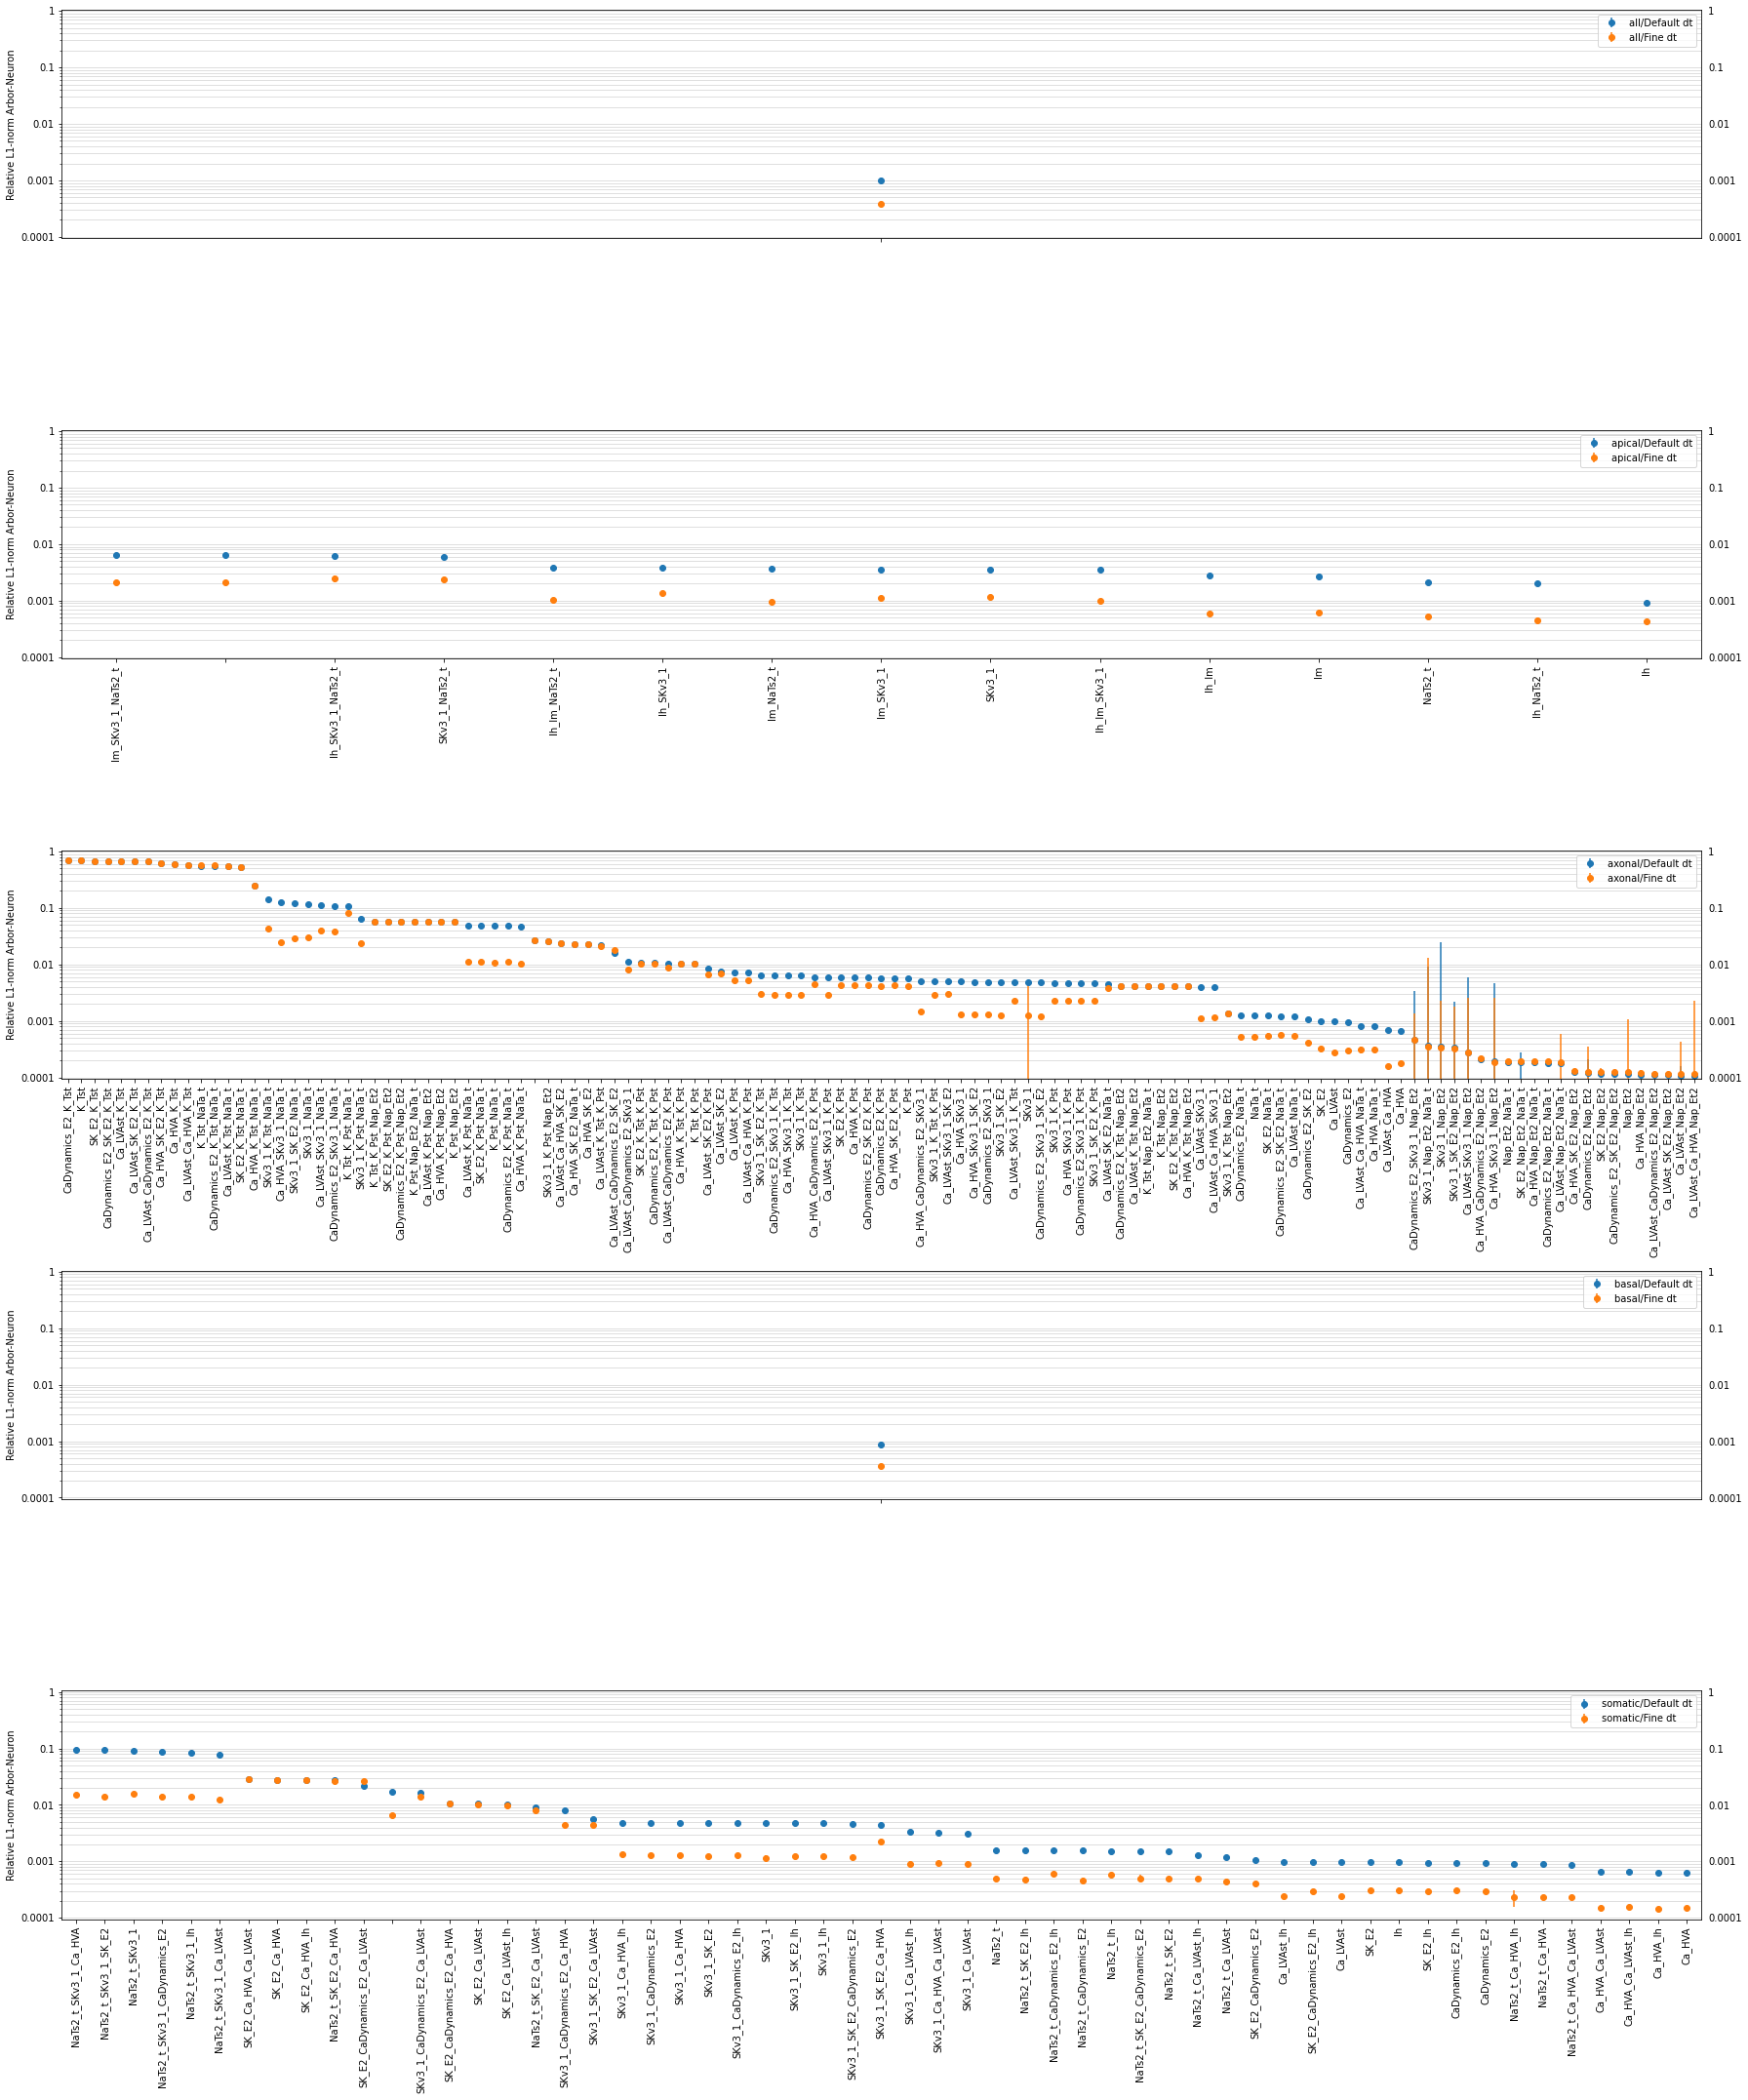

In [8]:
fig, axs = plt.subplots(len(regional_test_status), 1, sharey=True, figsize=(25, 6*len(regional_test_status)))

def show_test_status(ax, region, test_status_df, extra_label=''):
    for dt_setting, dt_group in test_status_df.groupby('dt_setting'):
        ax.errorbar(dt_group['mechs_str'],
                    dt_group['l1_norm'], yerr=dt_group['l1_error'], fmt='o', label= region + '/' + dt_setting + ' dt' + extra_label)
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(labelright=True)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2g"))
    ax.grid(visible=True, which='both', axis='y', alpha=0.5)
    ax.set_ylabel('Relative L1-norm Arbor-Neuron')
    ax.set_xlim(-0.5,len(dt_group)-0.5)
    ax.legend()
    

for i, (region, regional_test_status_df) in enumerate(regional_test_status.items()):
    show_test_status(axs[i], region, regional_test_status_df)
fig.tight_layout()
plt.show()

Repeating these plots on `axonal` and `somatic` regions for only the combinations with the highest-ranked mechanisms helps to get a better overview.

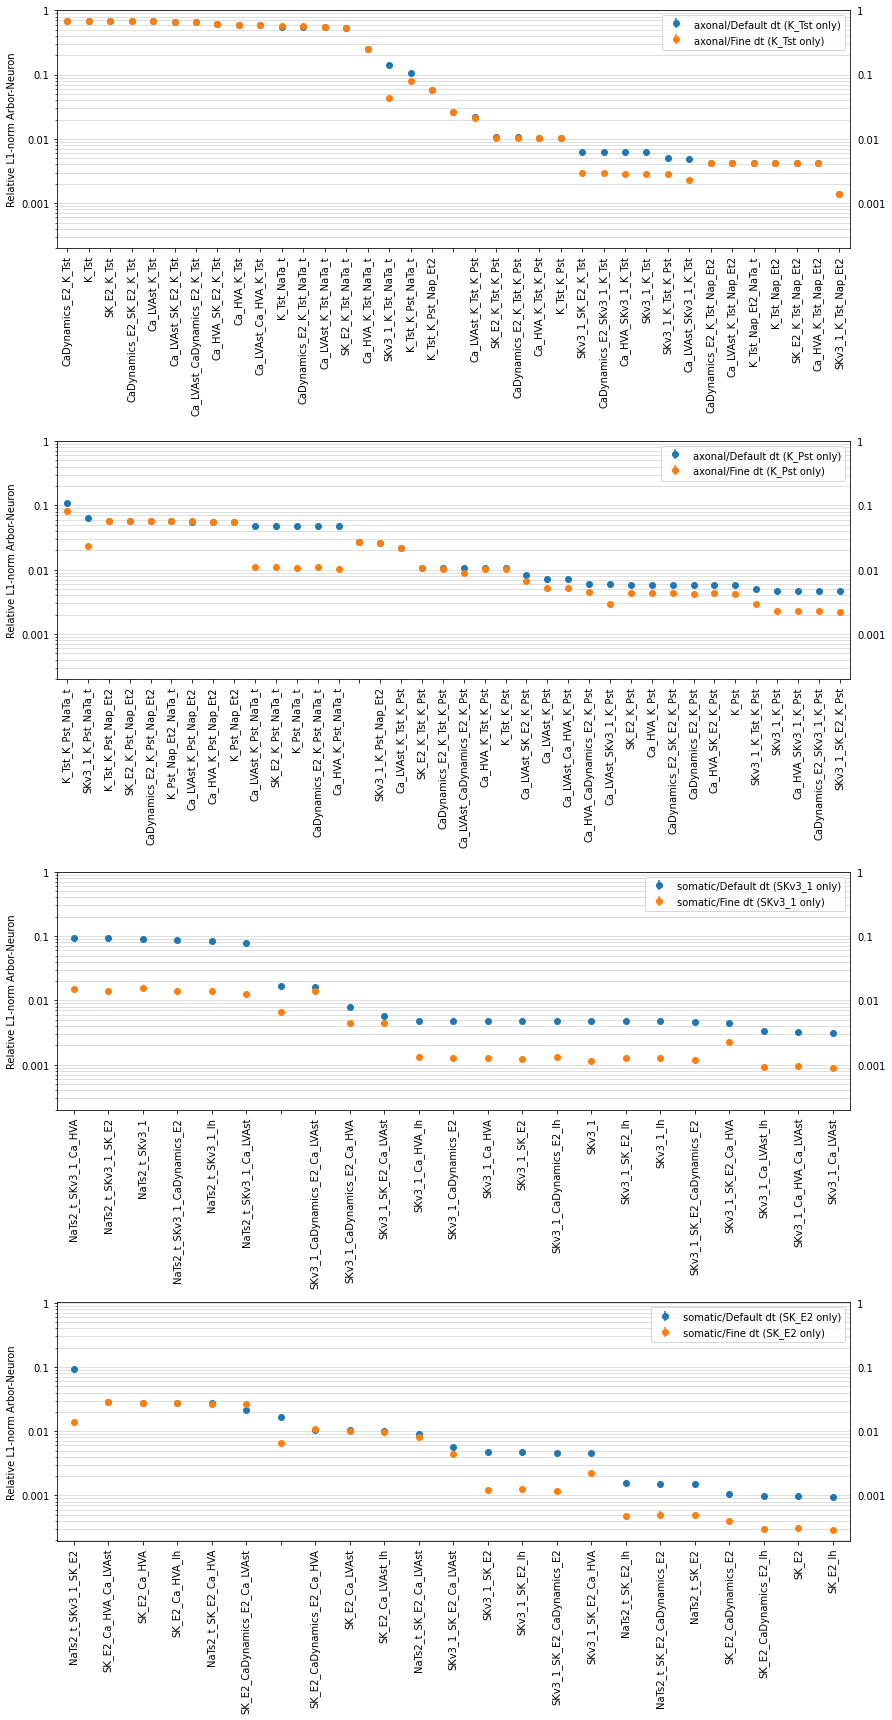

In [9]:
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12.5, 6*4))

mech_rank_stats['axonal']['Fine']['mech'].head(2)
mech_rank_stats['somatic']['Fine']['mech'].head(2)

i = 0
for region in ['axonal', 'somatic']:
    for mech in mech_rank_stats[region]['Fine']['mech'].head(2):
        show_test_status(axs[i],
                         region,
                         regional_test_status[region][regional_test_status[region]['mechs'].apply(lambda mechs: mech in mechs[region])],
                         ' (' + mech + ' only)')
        i += 1
        
fig.tight_layout()
plt.show()

Tests with N/A result obtained above:

In [10]:
%%bash

cat tests_na

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_K_Tst.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2_SK_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_CaDynamics_E2_NaTa_t.ipynb
l5pc_validate_neuron_arbor_axonal_Ca_LVAst_Ca_HVA_CaDynamics_E2.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst_Ih.ipynb
l5pc_validate_neuron_arbor_somatic_CaDynamics_E2_Ca_LVAst.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_HVA.ipynb
l5pc_validate_neuron_arbor_somatic_NaTs2_t_CaDynamics_E2_Ca_LVAst.ipynb


Usually this is due to failing to advance time-integration in NEURON. Printing all other cases here.

In [11]:
%%bash

for f in $(cat tests_na); do
    if ! grep NEURON:\ variable\ step\ integrator\ error $f > /dev/null; then
         echo $f
    fi
done

The error messages contain more info.

In [12]:
%%bash

grep -C 1 CVode $(cat tests_na)

l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x4353540 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode-- At t = 59.0538 and h = 2.94441e-08, the corrector\n",
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-      "convergence failed repeatedly or with |h| = hmin.\n",
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb:      "CVode 0x4353540 simple_cell[0].soma[0] advance_tn failed, err=-7.\n"
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     ]
--
l5pc_validate_neuron_arbor_axonal_Ca_HVA_CaDynamics_E2.ipynb-     "text": [
l5pc_validate_neuron_arbo